<a href="https://colab.research.google.com/github/haituly/Stress-Detection-Machine-Learning/blob/main/Stress_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stress Detection

For this project, i will use public stress dataset from Kaggel, and i will create a text stress detector using Bernoullie Naive Bayes algorithm machine learning.

https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction

https://www.kaggle.com/datasets/shuvojitdas/stress-analysis

# Import important libraries

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import nltk
import re
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stemmer = nltk.SnowballStemmer("english")


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import dataset

In [51]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [52]:
cd gdrive/MyDrive/Stress_Detection_Dataset

[Errno 2] No such file or directory: 'gdrive/MyDrive/Stress_Detection_Dataset'
/content/gdrive/MyDrive/Stress_Detection_Dataset


In [ ]:
train_data = pd.read_csv("Train_2018.txt",sep='\t', error_bad_lines=False, warn_bad_lines=True)
stress_data = pd.read_csv("stress.csv")
stress2_data = pd.read_csv("stress2.csv")

## Data Observation

In [109]:
stress2_data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [110]:
stress_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Columns: 116 entries, subreddit to sentiment
dtypes: float64(106), int64(6), object(4)
memory usage: 2.5+ MB


In [111]:
stress2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


## Preprocessing data

### Filtering data

Creating dataset which contains only texts and stress columns.

In [112]:
label_stress_data = stress_data[["text", "label"]]
label_stress_data.rename(columns={"label": "stress"}, inplace=True) #rename 'label' column to 'stress'
label_stress_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2838 non-null   object
 1   stress  2838 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.5+ KB


<ipython-input-112-6be57cb90974>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_stress_data.rename(columns={"label": "stress"}, inplace=True) #rename 'label' column to 'stress'


In [113]:
label_stress2_data = stress2_data[["text", "label"]]
label_stress2_data.rename(columns={"label": "stress"}, inplace=True) #rename 'label' column to 'stress'
label_stress2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2838 non-null   object
 1   stress  2838 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.5+ KB


<ipython-input-113-be2967b3e29b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_stress2_data.rename(columns={"label": "stress"}, inplace=True) #rename 'label' column to 'stress'


### Combining data

In [114]:
data = pd.concat([label_stress_data, label_stress2_data])

In [115]:
print(data.isnull().sum())

text      0
stress    0
dtype: int64


Let's take a look on the number of stress and no-stress of the combine dataset.

In [116]:
no_stress_df = data[data["stress"] == 0]
stress_df = data[data["stress"]== 1]

In [117]:
num_stress = len(stress_df)
num_no_stress = len(no_stress_df)
print(num_stress)
print(num_no_stress)

2976
2700


Number of Stress:  2976
Number of No Stress:  2700


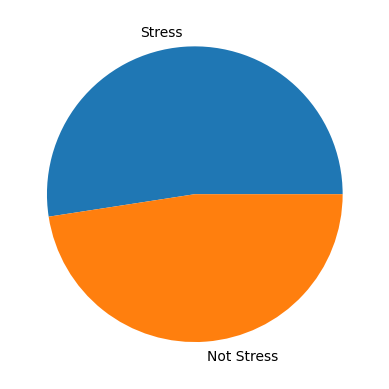

In [118]:
labels = ["Stress", "Not Stress"]
values = [sum(data["stress"] == 1), sum(data["stress"] == 0)]

plt.pie(values, labels = labels)
print("Number of Stress: ", sum(data["stress"] == 1))
print("Number of No Stress: ", sum(data["stress"] == 0))

### Cleaning texts

We will clean text column by removing punctuations, extra-characters, stopword, and stemming words.

In [119]:
def clean_text(text):
  text = str(text).lower()
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub('\[.*?\]', '', text) #remove square brackets and contents
  text = re.sub('https?://\S+|www\.\S+', '', text) #remove 'https'
  text = re.sub('<.*?>+', '', text) #remove html tags
  text = re.sub('\n', '', text) #remove newline characters
  text = [word for word in text.split() if word not in stopwords.words('english')] #remove stopwords
  text=" ".join(text)
  return text

In [90]:
data["text"] = data["text"].apply(clean_text)

In [121]:
print(data.sample(5))

                                                   text  stress
2561  This month and last have been very touch and g...       1
2607  This is my first post on reddit and I am seeki...       1
1301  Hey, r/Anxiety! &#x200B; I'm an undergraduate ...       0
882   A lot of very helpful things can be found here...       0
1575  Hi everyone, and thank you in advance for read...       1


## Building model

### Bag of Word

Converting texts into vectors

In [74]:
x = np.array(data["text"])
y = np.array(data["stress"])

In [75]:
cv = CountVectorizer()
X = cv.fit_transform(x)

### Splitting dataset into train and test

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

### Training model

In [98]:
model = BernoulliNB()
detect = model.fit(X_train, y_train)

In [99]:
pred_train = detect.predict(X_train)
pred_test = detect.predict(X_test)

## Evaluating model

In [102]:
pred_train = detect.predict(X_train) # Evaluate on train_dataset
print('Classification Report: \n', classification_report(y_train, pred_train))
print('Confusion matrix: \n', confusion_matrix(y_train, pred_train), '\n')
print('Accuracy: \n', accuracy_score(y_train, pred_train))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      1896
           1       0.93      0.98      0.96      2077

    accuracy                           0.95      3973
   macro avg       0.96      0.95      0.95      3973
weighted avg       0.96      0.95      0.95      3973

Confusion matrix: 
 [[1748  148]
 [  35 2042]] 

Accuracy: 
 0.9539390888497357


In [103]:
pred_test = detect.predict(X_test) # Evaluate on test dataset
print('Classification Report: \n', classification_report(y_test, pred_test))
print('Confusion matrix: \n', confusion_matrix(y_test, pred_test), '\n')
print('Accuracy: \n', accuracy_score(y_test, pred_test))

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.78      0.85       804
           1       0.83      0.95      0.89       899

    accuracy                           0.87      1703
   macro avg       0.88      0.87      0.87      1703
weighted avg       0.88      0.87      0.87      1703

Confusion matrix: 
 [[630 174]
 [ 47 852]] 

Accuracy: 
 0.8702290076335878


In [106]:
user = input("Enter a Text: ")
set = cv.transform([user]).toarray()
output = detect.predict(set)
print(output)

Enter a Text: I am so worried I don't know if I am going to fail the class
[1]


# Conclusion

The model's accuracy is about 87% which is considered a strong predictor. 